In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import seaborn as sns
from plotting_utilities import sim_colors, sim_ls, sexy_axes2

In [2]:
farbe = sim_colors()
stil = sim_ls()

# Figure S2: Diurnal cycle in LW / SW heating rates

In [ ]:
# Load heating rates for 1- and 2-moments, 24-hours, LW + SW, and 120 pressure levels.
H = np.zeros((2,24,2,120))
H[0] = np.load('./output/Zenodo-article1/H_1V1M0A0R_PL2.npy')
H[1] = np.load('./output/Zenodo-article1/H_1V2M0A0R_PL2.npy')
colors = plt.cm.jet(np.linspace(0,1,24))

# Load the pressure levels
pl = np.loadtxt('./remapping/PMEAN_48-72.txt')

# Labels
let = [['(a) 1V1M0A0R', '(c)'],['(b) 1V2M0A0R', '(d)']]

In [ ]:
fs = 17
fig, ax = plt.subplots(nrows=2,ncols=2,figsize=(10,10.5))
for j in [0,1]:
    for i in np.arange(24):
        ax[0,j].plot(H[j,i,0],pl/100, color=colors[i], alpha=0.5, linewidth=1.8)
        ax[1,j].plot(H[j,i,1],pl/100, color=colors[i], alpha=0.5, linewidth=1.8)
        ax[0,j].plot([0,0], [50,1000], lw=0.5, alpha=0.2, linestyle='--', color='k')
        ax[1,j].plot([0,0], [50,1000], lw=0.5, alpha=0.2, linestyle='--', color='k')
        ax[0,j].set_xlim([-1.25, 1.5])
        ax[1,j].set_xlim([-0.75, 2])
        ax[0,j].text(0.5, 0.8, let[j][0], fontsize=fs, weight='normal', transform=ax[0,j].transAxes)
        ax[1,j].text(0.5, 0.8, let[j][1], fontsize=fs, weight='normal', transform=ax[1,j].transAxes)
    ax[0,j].plot(np.nanmedian(H[j,:,0],axis=0),pl/100, color='k',linewidth=2)
    ax[1,j].plot(np.nanmedian(H[j,:,1],axis=0),pl/100, color='k',linewidth=2)
        
    sexy_axes2(ax[0,j], fs, True)
    sexy_axes2(ax[1,j], fs, True)

ax[1,0].set_xlabel(r'SW cloud-radiative heating [K day$^{-1}$]',fontsize=fs-2)
ax[1,1].set_xlabel(r'LW cloud-radiative heating [K day$^{-1}$]',fontsize=fs-2)
ax[1,1].set_ylabel('')
ax[0,1].set_ylabel('')
    
fig.savefig('./output/diurnal-cycle.pdf',bbox_inches='tight')

# Fig S3: IWP distribution and ice mass absorption coefficient

In [16]:
# Load the integrated column ice values from the 1- and 2-moment simulations
basedir = '/work/bb1018/b380873/model_output/ICON/'
#TQI_fi = xr.open_dataset(basedir + 'TQI_ALL_0V1M0A0R.nc')
#TQI_1mom = TQI_fi.tqi.sel(lon=slice(55,115)).values.flatten()
TQI_fi = xr.open_dataset(basedir + 'TQI_24h_1V1M0A0R.nc')
TQI_1mom = TQI_fi.tqi.values.flatten()
TQI_1mom = TQI_1mom[(TQI_1mom >= 10**(-8)) & (TQI_1mom <= 100)]

basedir = '/work/bb1018/b380873/model_output/ICON/'
#TQI_fi = xr.open_dataset(basedir + 'TQI_120-141_1V2M0A0R.nc')
#TQI_2mom = TQI_fi.tqi.values.flatten()
TQI_fi = xr.open_dataset(basedir + 'TQI_24h_1V2M0A0R.nc')
TQI_2mom = TQI_fi.tqi.values.flatten()
TQI_2mom = TQI_2mom[(TQI_2mom >= 10**(-8)) & (TQI_2mom <= 100)]

print(np.nanmean(TQI_2mom))
print(np.nanmean(TQI_1mom))

0.10118083
0.02778213


In [17]:
# Ice density [kg m-3]
rho_ice = 920

ice_opt = np.genfromtxt('/work/bb1018/b380873/rrtm/output/ice_optical_properties.txt')
# Wavelength [um]
lamb = ice_opt[:,0]
# Wavenumbers [cm-1] as above
wn_ice = 1./lamb*10**(4)
# Imaginary part of the index of refraction
mim = ice_opt[:,2]
# Calculate the ice mass absorption coefficient from m_im. [m2 kg-1]
# Note that we have to make an assumption about ice density here.
sigma_ice = 4*np.pi*mim/(lamb*10**(-6))/rho_ice

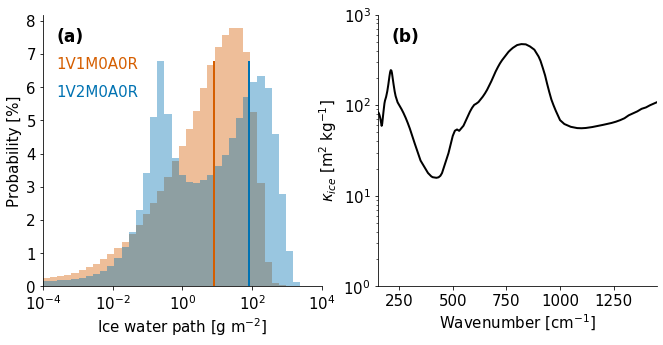

In [20]:
fs = 15
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(11,5))
d = -4; u = 4; b = 40
wgts = np.ones_like(TQI_1mom)/float(len(TQI_1mom))*100
sns.distplot(TQI_1mom*1000, kde=False, hist=True, kde_kws={'shade':True,'linewidth':3},\
   label=r'1V1M0A0R', bins=np.logspace(d,u,b), color=farbe['1V1M0A0R'], hist_kws={'weights':wgts}, ax=ax[0])

wgts = np.ones_like(TQI_2mom)/float(len(TQI_2mom))*100
sns.distplot(TQI_2mom*1000, kde=False, hist=True, kde_kws={'shade':True,'linewidth':3},\
   label=r'2-mom', bins=np.logspace(d,u,b), color=farbe['1V2M0A0R'], hist_kws={'weights':wgts}, ax = ax[0])

ax[0].plot([np.nanmedian(TQI_1mom)*1000, np.nanmedian(TQI_1mom)*1000],[0,6.75],color=farbe['1V1M0A0R'],linewidth=2)
ax[0].plot([np.nanmean(TQI_2mom)*1000, np.nanmean(TQI_2mom)*1000],[0,6.75],color=farbe['1V2M0A0R'],linewidth=2)
ax[0].set_xscale('log')
ax[0].set_xlim([10**(-4),10**4])
ax[0].set_xlabel(r'Ice water path [g m$^{-2}$]',fontsize=fs)
ax[0].set_ylabel('Probability [%]',fontsize=fs)
ax[0].text(0.05,0.9,'(a)',weight='bold',fontsize=fs+2,transform=ax[0].transAxes)
ax[0].text(0.05,0.8,'1V1M0A0R',fontsize=fs,color=farbe['1V1M0A0R'],transform=ax[0].transAxes)
ax[0].text(0.05,0.7,'1V2M0A0R',fontsize=fs,color=farbe['1V2M0A0R'],transform=ax[0].transAxes)
ax[0].tick_params('both',labelsize=fs)
ax[0].spines['right'].set_color('none')
ax[0].spines['top'].set_color('none')

ax[1].plot(wn_ice,sigma_ice,color='k',linewidth=2)
ax[1].text(0.05,0.9,'(b)',weight='bold',fontsize=fs+2,transform=ax[1].transAxes)
ax[1].set_xlabel(r'Wavenumber [cm$^{-1}$]',fontsize=fs)
ax[1].set_ylabel(r'$\kappa_{ice}$ [m$^{2}$ kg$^{-1}$]',fontsize=fs)
ax[1].set_yscale('log')
ax[1].tick_params(labelsize=fs,axis='both',which='major')
ax[1].set_xlim([150,1450])  # infrared range
ax[1].set_ylim([1,1000]) # infrared range
ax[1].tick_params(labelsize=fs)
ax[1].spines['right'].set_color('none')
ax[1].spines['top'].set_color('none')

#fig.savefig('output/iwp-kappa-ice.pdf')

# Fig S4: Vertical velocity profiles

In [27]:
# Load the vertical velocity values
WT_1V2M0A0R = np.load('output/Zenodo-article1/WT_1V2M0A0R_PL2.npy')
WT_0V1M0A0R = np.load('output/Zenodo-article1/WT_0V1M0A0R_PL2.npy')
WT_1V1M0A0R = np.load('output/Zenodo-article1/WT_1V1M0A0R_PL2.npy')
WT_0V2M0A0R = np.load('output/Zenodo-article1/WT_0V2M0A0R_PL2.npy')

# Retrieve the pressure levels
pl = np.loadtxt('remapping/PMEAN_48-72.txt')

In [30]:
print((np.nanpercentile(WT_1V1M0A0R[:,0],p,axis=0) - np.nanpercentile(WT_0V1M0A0R[:,0],p,axis=0))*100)

[-0.00124219 -0.00543166 -0.01261406 -0.01027782 -0.01544898 -0.00597717
 -0.00762265  0.00245203  0.00534819  0.00546873 -0.00641143 -0.00590242
  0.00350682 -0.01102898 -0.0138113  -0.02465023 -0.01639906  0.02016789
  0.08692464  0.13292778  0.15670505  0.15785777  0.14760369  0.14437685
  0.14541579  0.12860734  0.10528765  0.04915388 -0.060743   -0.03655945
 -0.00919911  0.00262635  0.00697671  0.02113027  0.03614561  0.05492173
  0.05015461  0.04807994  0.04579412  0.04531821  0.05518728  0.06455188
  0.08561317  0.10292718  0.10985082  0.11146606  0.11328772  0.11591618
  0.12877437  0.12821601  0.12680049  0.12437013  0.14755786  0.1900863
  0.2077279   0.21948463  0.22440533  0.24078097  0.29154581  0.31225393
  0.46388558  0.48957976  0.493897    0.49825305  0.5117386   0.49241123
  0.45570082  0.42893839  0.31994705  0.29929944  0.27606121  0.2682175
  0.26042864  0.25225227  0.23915445  0.20624802  0.19219518  0.18612551
  0.12036058  0.11621068  0.12382003  0.1192131   0.1

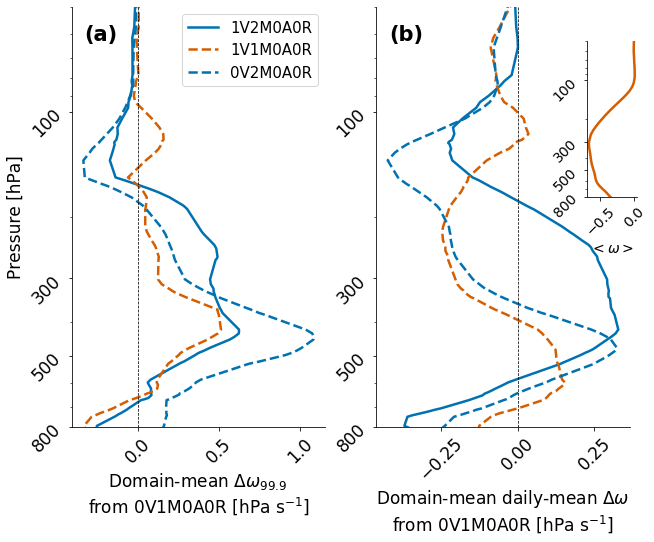

In [32]:
fs = 17
lw = 2.5
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(10,8))
p = 0.01
ax[0].plot((np.nanpercentile(WT_1V2M0A0R[:,0],p,axis=0) - np.nanpercentile(WT_0V1M0A0R[:,0],p,axis=0))*100,
       pl/100, color=farbe['1V2M0A0R'], label='1V2M0A0R', linewidth=lw)
ax[0].plot((np.nanpercentile(WT_1V1M0A0R[:,0],p,axis=0) - np.nanpercentile(WT_0V1M0A0R[:,0],p,axis=0))*100,
       pl/100,color=farbe['0V1M0A0R'], linestyle='--', label='1V1M0A0R', linewidth=lw)
ax[0].plot((np.nanpercentile(WT_0V2M0A0R[:,0],p,axis=0) - np.nanpercentile(WT_0V1M0A0R[:,0],p,axis=0))*100,\
       pl/100, color=farbe['0V2M0A0R'], linestyle='--', label='0V2M0A0R', linewidth=lw)
ax[0].plot([0,0], [50,800], lw=0.75, linestyle='--', color='k')
ax[0].set_ylabel('Pressure [hPa]',fontsize=fs)
ax[0].set_xlabel(r'Domain-mean $\Delta\omega_{99.9}$ '
                  '\n'
                 'from 0V1M0A0R [hPa s$^{-1}$]',fontsize=fs)
ax[0].text(0.05, 0.92, '(a)', weight='bold', fontsize=fs+4, transform=ax[0].transAxes)
sexy_axes2(ax[0], fs, True)
ax[0].legend(loc='upper right',fontsize=fs-2)

#ax2 = fig.add_axes([0.38,0.45,0.07,0.27])
#ax2.plot(np.percentile(WT_1mom[:,0],p,axis=0)*100,pl/100,color='red',label='_nolegend_')
#ax2.set_xlabel('$\omega_{99.9}$',fontsize=fs-3)
#sexy_axes2(ax2,fs-3,False,False)
#plt.gcf().subplots_adjust(bottom=0.15)

ax[1].plot((np.nanmean(WT_1V2M0A0R[:,0],axis=0) - np.nanmean(WT_0V1M0A0R[:,0],axis=0))*100, pl/100,
       color=farbe['1V2M0A0R'], linewidth=lw)
ax[1].plot((np.nanmean(WT_1V1M0A0R[:,0],axis=0) - np.nanmean(WT_0V1M0A0R[:,0],axis=0))*100,pl/100,
       color=farbe['1V1M0A0R'], linestyle='--', linewidth=lw)
ax[1].plot((np.nanmean(WT_0V2M0A0R[:,0],axis=0) - np.nanmean(WT_0V1M0A0R[:,0],axis=0))*100,pl/100,
       color=farbe['0V2M0A0R'], linestyle='--', linewidth=lw)
ax[1].plot([0,0], [50,800], lw=0.75, linestyle='--', color='k')
ax[1].set_xlabel(r'Domain-mean daily-mean $\Delta\omega$'
                 '\n'
                 'from 0V1M0A0R [hPa s$^{-1}$]',fontsize=fs)
ax[1].text(0.05, 0.92, '(b)', weight='bold', fontsize=fs+4, transform=ax[1].transAxes)
sexy_axes2(ax[1], fs, False)

ax2 = fig.add_axes([0.84,0.55,0.07,0.27])
ax2.plot(np.nanmean(WT_0V1M0A0R[:,0],axis=0)*10, pl/100, lw=lw, color=farbe['0V1M0A0R'], label='_nolegend_')
ax2.set_xlabel('$<\omega>$', fontsize=fs-3)
sexy_axes2(ax2, fs-3, False)
plt.gcf().subplots_adjust(bottom=0.15)

fig.savefig('./output/w-profiles.pdf', bbox_inches='tight')

### Make the vertical velocity profiles panel by panel

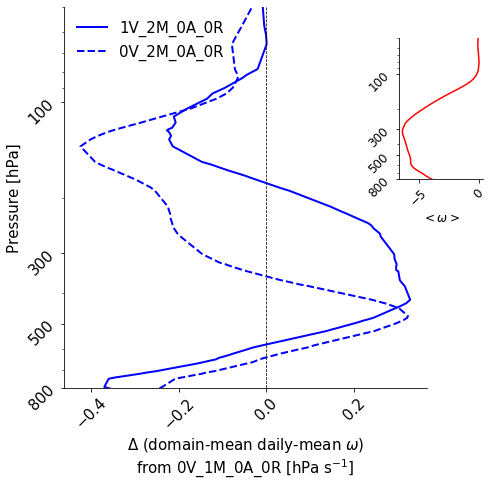

In [22]:
fig = plt.figure(figsize=(6.5,7.25))
plt.plot((np.nanmean(WT_2mom[:,0],axis=0)-np.nanmean(WT_1mom[:,0],axis=0))*100,pl/100,\
       color='blue',label='1V_2M_0A_0R',linewidth=2)
plt.plot((np.nanmean(WT_novgrid[:,0],axis=0)-np.nanmean(WT_1mom[:,0],axis=0))*100,pl/100,\
       color='blue',linestyle='--',label='0V_2M_0A_0R',linewidth=2)
plt.plot([0,0],[50,800],lw=0.75,linestyle='--',color='k')
plt.gca().set_xlabel(r'$\Delta$ (domain-mean daily-mean $\omega$)'
                 '\n'
                 'from 0V_1M_0A_0R [hPa s$^{-1}$]',fontsize=fs)
sexy_axes2(plt.gca(),fs,True,False)
plt.legend(loc='upper left',fontsize=fs,frameon=False)

ax2 = fig.add_axes([0.84,0.55,0.18,0.27])
ax2.plot(np.nanmean(WT_2mom[:,0],axis=0)*100,pl/100,color='red',label='_nolegend_')
ax2.set_xlabel('$<\omega>$',fontsize=fs-3)
sexy_axes2(ax2,fs-3,False,False)
plt.gcf().subplots_adjust(bottom=0.15)

#fig.savefig('output/w-mean-profile.pdf',bbox_inches='tight')

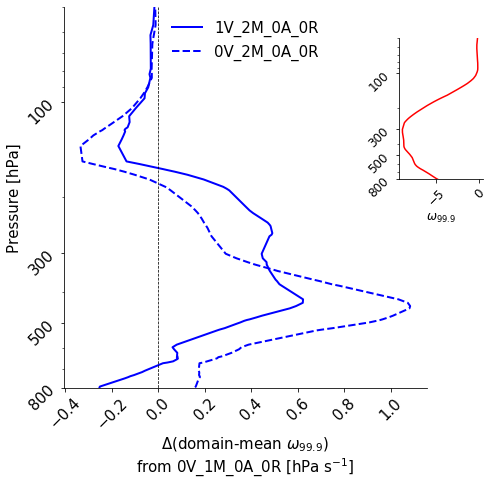

In [34]:
fig = plt.figure(figsize=(6.5,7.25))
p = 0.01
plt.plot((np.percentile(WT_2mom[:,0],p,axis=0)-np.percentile(WT_1mom[:,0],p,axis=0))*100,\
       pl/100,color='blue',label='1V_2M_0A_0R',linewidth=2)
plt.plot((np.percentile(WT_novgrid[:,0],p,axis=0)-np.percentile(WT_1mom[:,0],p,axis=0))*100,\
       pl/100,color='blue',linestyle='--',label='0V_2M_0A_0R',linewidth=2)
plt.plot([0,0],[50,800],lw=0.75,linestyle='--',color='k')
plt.gca().set_ylabel('Pressure [hPa]',fontsize=fs)
plt.gca().set_xlabel(r'$\Delta$(domain-mean $\omega_{99.9}$) '
                  '\n'
                 'from 0V_1M_0A_0R [hPa s$^{-1}$]',fontsize=fs)
sexy_axes2(plt.gca(),fs,True,False)
plt.legend(loc='upper center',fontsize=fs,frameon=False)

p=0.001
ax2 = fig.add_axes([0.84,0.55,0.18,0.27])
ax2.plot(np.percentile(WT_1mom[:,0],p,axis=0)*120,pl/100,color='red',label='_nolegend_')
ax2.set_xlabel('$\omega_{99.9}$',fontsize=fs-3)
sexy_axes2(ax2,fs-3,False,False)
plt.gcf().subplots_adjust(bottom=0.15)

fig.savefig('output/w99-profile.pdf',bbox_inches='tight')

## Temperature profiles out of curiosity

In [33]:
guy = np.load('output/Zenodo-article1/WT_1V2M1A1R_PL2_flipped.npy')
print(guy.shape)
guy = np.reshape(guy,[24,2,120])
print(guy.shape)
#nanny = np.empty((12, 2, 120))
#nanny[:] = np.nan
#combined = np.concatenate((guy,nanny),axis=0)
#print(combined.shape)
np.save('output/Zenodo-article1/WT_1V2M1A1R_PL2.npy',guy)

(2, 24, 120)
(24, 2, 120)


0V1M0A0R
0V2M0A0R


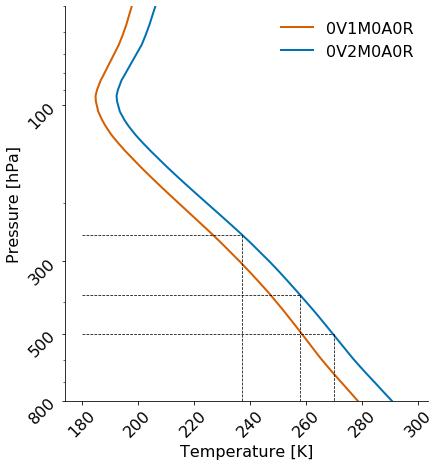

In [45]:
fs = 16
acronym = ['0V1M0A0R', '0V2M0A0R']#, '0V2M0A1R', '0V2M1A1R']#, '1V1M0A0R', 
           #'1V2M0A0R', '1V2M0A1R', '1V2M1A1R', '1V2M1A0R'] #'0V2M1A0R', 
ll = len(acronym)
WT_all = np.zeros((ll, 24, 2, 120))
for indx, o in enumerate(acronym):
    print(o)
    WT_all[indx] = np.load('output/Zenodo-article1/WT_' + o + '_PL2.npy')
    
fig = plt.figure(figsize=(6.5,7.25))
for i, a, wt in zip(np.arange(len(acronym)), acronym, WT_all):
    plt.plot(np.nanmean(wt[:,1],axis=0), pl/100, color=farbe[a], label=a, linewidth=2)

plt.plot([180, 258],[380, 380], color='k', linestyle='--', linewidth=0.75)
plt.plot([258, 258],[380, 800], color='k', linestyle='--', linewidth=0.75)

plt.plot([180, 270],[500, 500], color='k', linestyle='--', linewidth=0.75)
plt.plot([270, 270],[500, 800], color='k', linestyle='--', linewidth=0.75)

plt.plot([180, 237],[250, 250], color='k', linestyle='--', linewidth=0.75)
plt.plot([237, 237],[250, 800], color='k', linestyle='--', linewidth=0.75)

plt.gca().set_xlabel('Temperature [K]', fontsize=fs)
sexy_axes2(plt.gca(),fs, True)
plt.legend(loc='upper right', fontsize=fs, frameon=False)

#ax2 = fig.add_axes([0.84,0.55,0.18,0.27])
#ax2.plot(np.nanmean(WT_2mom[:,0],axis=0)*100,pl/100,color='red',label='_nolegend_')
#ax2.set_xlabel('$<\omega>$',fontsize=fs-3)
#sexy_axes2(ax2,fs-3,False,False)
#plt.gcf().subplots_adjust(bottom=0.15)

# Fig S5: Cloud liquid mixing ratio profiles

In [19]:
acronym = ['0V1M0A0R', '1V1M0A0R', '0V2M0A0R', '1V2M0A0R', '0V2M0A1R', '1V2M0A1R',
          '0V2M1A0R', '1V2M1A0R', '0V2M1A1R', '1V2M1A1R']
ll = len(acronym)
QC_all = np.zeros((ll, 24, 120))
for indx, o in enumerate(acronym):
    QC_all[indx] = np.load('output/Zenodo-article1/QC_' + o + '_PL2.npy')

# Retrieve the pressure levels
pl = np.loadtxt('remapping/PMEAN_48-72.txt')
farbe = sim_colors()
stil = sim_ls()

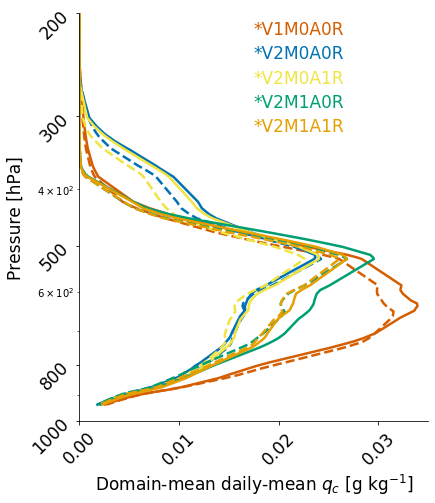

In [20]:
fs = 17
fig = plt.figure(figsize=(6.25,7.5))
for j, q, a in zip(np.arange(len(acronym)), QC_all, acronym):
    plt.plot(np.nanmean(q,axis=0)*1000, pl/100, color=farbe[a], lw=2.5, ls=stil[a[:2]], label=o)
    if j%2 == 0:
        plt.text(0.5,0.95-0.03*j, '*' + a[1:], fontsize=fs, color=farbe[a], transform=plt.gca().transAxes)
    
plt.ylabel('Pressure [hPa]', fontsize=fs)
plt.xlabel(r'Domain-mean daily-mean $q_c$ [g kg$^{-1}$]', fontsize=fs)
#plt.legend()
ax = plt.gca()
ax.set_ylim([200, 1000])
ax.set_xlim([0, 0.035])
ax.set_yscale('log')
ax.set_yticks([1000, 800, 500, 300, 200])
ax.set_yticklabels(['1000', '800', '500', '300', '200'])
ax.invert_yaxis()

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
#ax.yaxis.set_ticks_position('left')
ax.tick_params('both',labelsize=fs,rotation=45)

fig.savefig('output/qc-profiles_all.pdf',bbox_inches='tight')
plt.show()
